In [43]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install webrtcvad --user

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 71kB 863kB/s ta 0:00:01
  Running setup.py bdist_wheel for webrtcvad ... done
  Stored in directory: /home/mpc6/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [60]:
import os
import soundfile as sf
#import sounddevice as sd
#import librosa
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio
import thinkdsp
import subprocess
from sklearn.model_selection import train_test_split
import pickle
# Keras packages model
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, GRU, Convolution1D, MaxPooling1D, Dropout, BatchNormalization, Flatten, concatenate 
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping
from keras import regularizers

SAMPLERATE = 8000
DATAPATH = 'data'
MINSIZE = 2000
MAXSIZE = 4500

In [82]:
# Download raw data from source
os.makedirs(DATAPATH, exist_ok=True)

url = 'http://www.dive-into.info/7577'
zips = ['numbers.zip', 'moreNumbers.zip']

for zipFile in zips:
    if os.path.exists(zipFile):
        os.remove(zipFile)
        
    get_url = os.path.join(url, zipFile)
    print('Downloading', zipFile)
    rtnVal = subprocess.call(['wget', get_url])
    print(zipFile, 'downloaded successfully')

    print('Unzipping', zipFile)
    rtnVal = subprocess.call(['unzip', zipFile, '-d', dataDir])
    print(zipFile, 'unzipped successfully')



numbers.zip downloaded successfully
Unzipping numbers.zip
numbers.zip unzipped successfully
moreNumbers.zip downloaded successfully
Unzipping moreNumbers.zip
moreNumbers.zip unzipped successfully


In [197]:
# Pre-process the data
def get_averages(samples, frameSize):
    averages = []
    for frame in range(0,len(samples), frameSize):
        averages.append(np.average(np.absolute(samples[frame:frame+frameSize])))

    return averages

def find_clusters(samples, averages, target, frameSize):
    startIdx = None
    endIdx = None
    clusters = []
    for idx, frame in enumerate(range(0,len(samples), frameSize)):
        #print('frame avg:', averages[idx])
        if averages[idx] > target and not startIdx:
            startIdx = idx
        if startIdx and not endIdx:
            if averages[idx] < target:
                endIdx = idx
        if startIdx and endIdx:
            clusters.append((startIdx,endIdx))
            startIdx = None
            endIdx = None

    # incase last frame is above average
    if startIdx != None and endIdx == None:
        endIdx = idx
        clusters.append((startIdx,endIdx))
        
    #print(averages[idx])
    return clusters

def find_longest_cluster(clusters):
    longestCluster = 0
    longestClusterSize = 0
    for cluster in clusters:
        clusterSize = cluster[1]-cluster[0]
        if clusterSize > longestClusterSize:
            longestClusterSize = clusterSize
            longestCluster = cluster

    return longestCluster

def clip_audio(samples):

    frameSize = 100
    averages = get_averages(samples, frameSize)
    target = np.average(averages)/2     # threshold, assume below this level is backround noise

    #print('target avg:', target)
    # find all audio clusters above target threshold
    clusters = find_clusters(samples, averages, target, frameSize)

    #for cluster in clusters:
    #    print(cluster[0]*frameSize, cluster[1]*frameSize)
    #print('Clusters:', clusters)
    
    # find longest audio cluster
    longestCluster = find_longest_cluster(clusters)
    
    print('Clipping samples', longestCluster[0]*frameSize, longestCluster[1]*frameSize)

    return samples[longestCluster[0]*frameSize:longestCluster[1]*frameSize+frameSize]

def clip_waves(rawAudioPath, clippedAudioPath):
    for fileName in glob.iglob(os.path.join(rawAudioPath, '*.wav')):
        print('File:', fileName)
        samples, sample_rate = sf.read(fileName )
        print("number of samples:", len(samples))

        # find largest cluster of audio and grab the samples
        clippedSamples = clip_audio(samples)

        # write clipped audio to file
        clippedFileName = os.path.join(clippedAudioPath, os.path.basename(fileName))
        sf.write(clippedFileName, clippedSamples, SAMPLERATE, subtype='PCM_16')
        print(fileName,' clipped and saved as ',clippedFileName)
        
def filter_audio(audioPath, outAudioPath, highCutoff, lowCutoff):
    print('Filter files in', audioPath, 'and saving to', outAudioPath)
    for fileName in glob.iglob(os.path.join(audioPath, '*.wav')):
        print('File:', fileName)
        sample = thinkdsp.read_wave(fileName)
        spectrum = sample.make_spectrum()
        spectrum.low_pass(cutoff=highCutoff, factor=0.01)
        spectrum.high_pass(cutoff=lowCutoff, factor=0.01)
        wave = spectrum.make_wave()
        outFileName = os.path.join(outAudioPath, os.path.basename(fileName))
        wave.play(outFileName)
    print('Filtering complete!')
    

vadScript = 'vad_wavs.py'
agressiveness = '3'
numbersDir = os.path.join(DATAPATH, 'numbers')
filteredDir = os.path.join(DATAPATH, 'filteredNums')
trainingDir = os.path.join(DATAPATH, 'trainingNums')
os.makedirs(filteredDir, exist_ok=True)
os.makedirs(trainingDir, exist_ok=True)

# High and low pass filter
highCutoff = 3400
lowCutoff = 300
#filter_audio(audioPath, filteredDir, highCutoff, lowCutoff)

# Saves voice from raw data
print('Saving voice activity from waves')
#rtnVal = subprocess.call(['python', vadScript, agressiveness, filteredDir, trainingDir])
clip_waves(filteredDir, trainingDir)
print('Finished saving voice activity')



Saving voice activity from waves
File: data/filteredNums/00_00c1b12173.wav
number of samples: 15702
Clipping samples 8500 11500
data/filteredNums/00_00c1b12173.wav  clipped and saved as  data/trainingNums/00_00c1b12173.wav
File: data/filteredNums/00_064009241a.wav
number of samples: 12404
Clipping samples 4200 7400
data/filteredNums/00_064009241a.wav  clipped and saved as  data/trainingNums/00_064009241a.wav
File: data/filteredNums/00_0666098465.wav
number of samples: 16326
Clipping samples 8700 11900
data/filteredNums/00_0666098465.wav  clipped and saved as  data/trainingNums/00_0666098465.wav
File: data/filteredNums/00_07c3627a21.wav
number of samples: 15702
Clipping samples 9300 13000
data/filteredNums/00_07c3627a21.wav  clipped and saved as  data/trainingNums/00_07c3627a21.wav
File: data/filteredNums/00_0a3c709caa.wav
number of samples: 16346
Clipping samples 10800 16300
data/filteredNums/00_0a3c709caa.wav  clipped and saved as  data/trainingNums/00_0a3c709caa.wav
File: data/filter

Clipping samples 3800 6900
data/filteredNums/01_0a167576bb.wav  clipped and saved as  data/trainingNums/01_0a167576bb.wav
File: data/filteredNums/01_0a78218273.wav
number of samples: 16326
Clipping samples 5900 11500
data/filteredNums/01_0a78218273.wav  clipped and saved as  data/trainingNums/01_0a78218273.wav
File: data/filteredNums/01_0b6cc89828.wav
number of samples: 16422
Clipping samples 2400 5700
data/filteredNums/01_0b6cc89828.wav  clipped and saved as  data/trainingNums/01_0b6cc89828.wav
File: data/filteredNums/01_1b7861c5b1.wav
number of samples: 15604
Clipping samples 5600 7600
data/filteredNums/01_1b7861c5b1.wav  clipped and saved as  data/trainingNums/01_1b7861c5b1.wav
File: data/filteredNums/01_1c7160c09b.wav
number of samples: 16422
Clipping samples 4400 8400
data/filteredNums/01_1c7160c09b.wav  clipped and saved as  data/trainingNums/01_1c7160c09b.wav
File: data/filteredNums/01_2007153070.wav
number of samples: 8386
Clipping samples 2100 5200
data/filteredNums/01_2007153

data/filteredNums/02_1189c1ac4c.wav  clipped and saved as  data/trainingNums/02_1189c1ac4c.wav
File: data/filteredNums/02_15cb34aa3c.wav
number of samples: 16384
Clipping samples 6900 8900
data/filteredNums/02_15cb34aa3c.wav  clipped and saved as  data/trainingNums/02_15cb34aa3c.wav
File: data/filteredNums/02_167387ca85.wav
number of samples: 15702
Clipping samples 8700 11800
data/filteredNums/02_167387ca85.wav  clipped and saved as  data/trainingNums/02_167387ca85.wav
File: data/filteredNums/02_177a9c03b9.wav
number of samples: 16346
Clipping samples 8600 15500
data/filteredNums/02_177a9c03b9.wav  clipped and saved as  data/trainingNums/02_177a9c03b9.wav
File: data/filteredNums/02_182c84c02a.wav
number of samples: 16422
Clipping samples 5600 9200
data/filteredNums/02_182c84c02a.wav  clipped and saved as  data/trainingNums/02_182c84c02a.wav
File: data/filteredNums/02_1c03b27896.wav
number of samples: 15604
Clipping samples 5600 9500
data/filteredNums/02_1c03b27896.wav  clipped and save

Clipping samples 7100 9100
data/filteredNums/03_46c79029ac.wav  clipped and saved as  data/trainingNums/03_46c79029ac.wav
File: data/filteredNums/03_4b644b13a9.wav
number of samples: 15702
Clipping samples 9100 11200
data/filteredNums/03_4b644b13a9.wav  clipped and saved as  data/trainingNums/03_4b644b13a9.wav
File: data/filteredNums/03_52786ca179.wav
number of samples: 15604
Clipping samples 9200 11600
data/filteredNums/03_52786ca179.wav  clipped and saved as  data/trainingNums/03_52786ca179.wav
File: data/filteredNums/03_52a79a6947.wav
number of samples: 15604
Clipping samples 9100 12000
data/filteredNums/03_52a79a6947.wav  clipped and saved as  data/trainingNums/03_52a79a6947.wav
File: data/filteredNums/03_5445bc32b1.wav
number of samples: 16346
Clipping samples 7100 10200
data/filteredNums/03_5445bc32b1.wav  clipped and saved as  data/trainingNums/03_5445bc32b1.wav
File: data/filteredNums/03_5b58b03427.wav
number of samples: 8386
Clipping samples 2300 5100
data/filteredNums/03_5b58

data/filteredNums/04_770a366ac2.wav  clipped and saved as  data/trainingNums/04_770a366ac2.wav
File: data/filteredNums/04_7878050014.wav
number of samples: 16326
Clipping samples 7800 10700
data/filteredNums/04_7878050014.wav  clipped and saved as  data/trainingNums/04_7878050014.wav
File: data/filteredNums/04_8262316582.wav
number of samples: 15702
Clipping samples 8000 10500
data/filteredNums/04_8262316582.wav  clipped and saved as  data/trainingNums/04_8262316582.wav
File: data/filteredNums/04_837a1b7321.wav
number of samples: 8322
Clipping samples 2800 4900
data/filteredNums/04_837a1b7321.wav  clipped and saved as  data/trainingNums/04_837a1b7321.wav
File: data/filteredNums/04_8521596509.wav
number of samples: 15604
Clipping samples 7100 10500
data/filteredNums/04_8521596509.wav  clipped and saved as  data/trainingNums/04_8521596509.wav
File: data/filteredNums/04_8bbc377cab.wav
number of samples: 16422
Clipping samples 5400 8100
data/filteredNums/04_8bbc377cab.wav  clipped and save

data/filteredNums/05_949ca66534.wav  clipped and saved as  data/trainingNums/05_949ca66534.wav
File: data/filteredNums/05_97154a1859.wav
number of samples: 16346
Clipping samples 9000 12300
data/filteredNums/05_97154a1859.wav  clipped and saved as  data/trainingNums/05_97154a1859.wav
File: data/filteredNums/05_9a77b5a549.wav
number of samples: 16384
Clipping samples 8800 12400
data/filteredNums/05_9a77b5a549.wav  clipped and saved as  data/trainingNums/05_9a77b5a549.wav
File: data/filteredNums/05_a8a50a4982.wav
number of samples: 16384
Clipping samples 10000 12600
data/filteredNums/05_a8a50a4982.wav  clipped and saved as  data/trainingNums/05_a8a50a4982.wav
File: data/filteredNums/05_a98b16575b.wav
number of samples: 16346
Clipping samples 10800 13600
data/filteredNums/05_a98b16575b.wav  clipped and saved as  data/trainingNums/05_a98b16575b.wav
File: data/filteredNums/05_aa49344497.wav
number of samples: 8322
Clipping samples 2700 4800
data/filteredNums/05_aa49344497.wav  clipped and s

number of samples: 16346
Clipping samples 5500 7500
data/filteredNums/06_9304302410.wav  clipped and saved as  data/trainingNums/06_9304302410.wav
File: data/filteredNums/06_971676b7ba.wav
number of samples: 16346
Clipping samples 7100 9700
data/filteredNums/06_971676b7ba.wav  clipped and saved as  data/trainingNums/06_971676b7ba.wav
File: data/filteredNums/06_9a7c09c325.wav
number of samples: 12404
Clipping samples 5400 6800
data/filteredNums/06_9a7c09c325.wav  clipped and saved as  data/trainingNums/06_9a7c09c325.wav
File: data/filteredNums/06_9b96cac655.wav
number of samples: 15604
Clipping samples 10600 12800
data/filteredNums/06_9b96cac655.wav  clipped and saved as  data/trainingNums/06_9b96cac655.wav
File: data/filteredNums/06_9cb7c3493c.wav
number of samples: 16346
Clipping samples 7200 10000
data/filteredNums/06_9cb7c3493c.wav  clipped and saved as  data/trainingNums/06_9cb7c3493c.wav
File: data/filteredNums/06_a1262901b1.wav
number of samples: 16346
Clipping samples 7500 10700

number of samples: 16346
Clipping samples 7700 10100
data/filteredNums/07_c5830b4616.wav  clipped and saved as  data/trainingNums/07_c5830b4616.wav
File: data/filteredNums/07_c794566c62.wav
number of samples: 15702
Clipping samples 7500 11200
data/filteredNums/07_c794566c62.wav  clipped and saved as  data/trainingNums/07_c794566c62.wav
File: data/filteredNums/07_ca27965b66.wav
number of samples: 16326
Clipping samples 7200 10500
data/filteredNums/07_ca27965b66.wav  clipped and saved as  data/trainingNums/07_ca27965b66.wav
File: data/filteredNums/08_031b177a04.wav
number of samples: 16346
Clipping samples 8400 10600
data/filteredNums/08_031b177a04.wav  clipped and saved as  data/trainingNums/08_031b177a04.wav
File: data/filteredNums/08_0b85c34668.wav
number of samples: 15604
Clipping samples 10100 11900
data/filteredNums/08_0b85c34668.wav  clipped and saved as  data/trainingNums/08_0b85c34668.wav
File: data/filteredNums/08_1562957659.wav
number of samples: 15604
Clipping samples 7700 94

Clipping samples 8400 11400
data/filteredNums/09_18a0890777.wav  clipped and saved as  data/trainingNums/09_18a0890777.wav
File: data/filteredNums/09_19c84a98aa.wav
number of samples: 16326
Clipping samples 6100 10800
data/filteredNums/09_19c84a98aa.wav  clipped and saved as  data/trainingNums/09_19c84a98aa.wav
File: data/filteredNums/09_1c3c509925.wav
number of samples: 16326
Clipping samples 5000 11100
data/filteredNums/09_1c3c509925.wav  clipped and saved as  data/trainingNums/09_1c3c509925.wav
File: data/filteredNums/09_2266607375.wav
number of samples: 12308
Clipping samples 3800 6900
data/filteredNums/09_2266607375.wav  clipped and saved as  data/trainingNums/09_2266607375.wav
File: data/filteredNums/09_29942a34ac.wav
number of samples: 16346
Clipping samples 8500 12500
data/filteredNums/09_29942a34ac.wav  clipped and saved as  data/trainingNums/09_29942a34ac.wav
File: data/filteredNums/09_2b167aa714.wav
number of samples: 16384
Clipping samples 6700 9300
data/filteredNums/09_2b1

number of samples: 16346
Clipping samples 10700 13600
data/filteredNums/10_47b4402284.wav  clipped and saved as  data/trainingNums/10_47b4402284.wav
File: data/filteredNums/10_49b7994420.wav
number of samples: 15604
Clipping samples 6200 8500
data/filteredNums/10_49b7994420.wav  clipped and saved as  data/trainingNums/10_49b7994420.wav
File: data/filteredNums/10_4aa683b943.wav
number of samples: 15604
Clipping samples 10100 13700
data/filteredNums/10_4aa683b943.wav  clipped and saved as  data/trainingNums/10_4aa683b943.wav
File: data/filteredNums/10_4c1c08b61b.wav
number of samples: 16384
Clipping samples 8700 12100
data/filteredNums/10_4c1c08b61b.wav  clipped and saved as  data/trainingNums/10_4c1c08b61b.wav
File: data/filteredNums/10_5089c98b04.wav
number of samples: 16384
Clipping samples 9800 13300
data/filteredNums/10_5089c98b04.wav  clipped and saved as  data/trainingNums/10_5089c98b04.wav
File: data/filteredNums/10_512063a695.wav
number of samples: 15604
Clipping samples 7700 96

data/filteredNums/11_5113ac9768.wav  clipped and saved as  data/trainingNums/11_5113ac9768.wav
File: data/filteredNums/11_51779cb141.wav
number of samples: 16384
Clipping samples 10300 13500
data/filteredNums/11_51779cb141.wav  clipped and saved as  data/trainingNums/11_51779cb141.wav
File: data/filteredNums/11_5589b5726b.wav
number of samples: 16384
Clipping samples 8200 10900
data/filteredNums/11_5589b5726b.wav  clipped and saved as  data/trainingNums/11_5589b5726b.wav
File: data/filteredNums/11_5608919417.wav
number of samples: 16346
Clipping samples 5100 9100
data/filteredNums/11_5608919417.wav  clipped and saved as  data/trainingNums/11_5608919417.wav
File: data/filteredNums/11_590c23a2c0.wav
number of samples: 15604
Clipping samples 5200 8800
data/filteredNums/11_590c23a2c0.wav  clipped and saved as  data/trainingNums/11_590c23a2c0.wav
File: data/filteredNums/11_5a13b80067.wav
number of samples: 15702
Clipping samples 8000 10700
data/filteredNums/11_5a13b80067.wav  clipped and sa

data/filteredNums/12_c781849751.wav  clipped and saved as  data/trainingNums/12_c781849751.wav
File: data/filteredNums/12_c79c32b4c1.wav
number of samples: 15604
Clipping samples 5900 9100
data/filteredNums/12_c79c32b4c1.wav  clipped and saved as  data/trainingNums/12_c79c32b4c1.wav
File: data/filteredNums/12_caa0924489.wav
number of samples: 15702
Clipping samples 7700 9500
data/filteredNums/12_caa0924489.wav  clipped and saved as  data/trainingNums/12_caa0924489.wav
File: data/filteredNums/12_cb098b4348.wav
number of samples: 16346
Clipping samples 8200 11200
data/filteredNums/12_cb098b4348.wav  clipped and saved as  data/trainingNums/12_cb098b4348.wav
File: data/filteredNums/12_cb19ccaa32.wav
number of samples: 16326
Clipping samples 5600 9800
data/filteredNums/12_cb19ccaa32.wav  clipped and saved as  data/trainingNums/12_cb19ccaa32.wav
File: data/filteredNums/12_cbb3c5acb3.wav
number of samples: 16346
Clipping samples 11300 13700
data/filteredNums/12_cbb3c5acb3.wav  clipped and sav

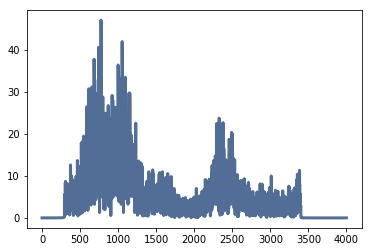

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7f08f89b08d0>>
Traceback (most recent call last):
  File "/usr/lib/python3.5/wave.py", line 316, in __del__
    self.close()
  File "/usr/lib/python3.5/wave.py", line 433, in close
    if self._file:
AttributeError: 'Wave_write' object has no attribute '_file'


In [142]:
#Examine a wave's spectrum
waveFile = 'data/trainingNums/05_620a81c69b-VAD.wav'
sample = thinkdsp.read_wave(waveFile)
spectrum = sample.make_spectrum()
#spectrum.low_pass(cutoff=3400, factor=0.01)
#spectrum.high_pass(cutoff=300, factor=0.01)
spectrum.plot()

In [2]:
# Dataset creation functions

def get_longest_samples(dataPath):
    longestNumSamples = 0
    shortestNumSamples = 16000

    numSamples = []
    #print('Finding longest wave file')
    for fileName in glob.iglob(os.path.join(dataPath, '*.wav')):
        #print('File:', fileName)
        data, sr = sf.read(fileName)
        if len(data) > MINSIZE and len(data) < MAXSIZE:
            numSamples.append(len(data))
        assert sr == SAMPLERATE, 'wave file is not correct sample rate!'
        if len(data) < shortestNumSamples and len(data) > MINSIZE:
            shortestNumSamples = len(data)
            #print('File:', fileName, shortestNumSamples)
        if len(data) > longestNumSamples and len(data) < MAXSIZE:
            longestNumSamples = len(data)
            #print('File:', fileName, longestNumSamples)

    print('Number of examples:', len(numSamples))
#    numSmallSamples = 0
#    numLargeSamples = 0
#    for num in numSamples:
#        if num < 2*frameSize:
#            numSmallSamples += 1
#            print(num)
#        if num > 8000:
#            numLargeSamples += 1
#            print(num)

#    print('Longest sample = ', longestNumSamples, numLargeSamples, '/', len(numSamples))
#    print('Shortest sample = ', shortestNumSamples, numSmallSamples, '/', len(numSamples))
    return longestNumSamples

def get_frame_magnitudes(samples, numFrames, frameSize, overlap, window):
    magnitudes = np.empty((0,frameSize//2 +1))
    #print(len(samples), frameSize, overlap)
    for frame in range(numFrames):
        frameStart = frame * frameSize - frame * overlap
        # start overlap after first frame
        #if frameStart > 0:
        #    frameStart -= overlap
        #print('FrameStart:',frameStart)
        data = samples[frameStart:frameStart+frameSize]
        #print(len(data), len(window))
        frameMags = np.fft.rfft(window*data)
        #print(frameMags.shape)
        magnitudes = np.vstack((magnitudes, np.real(np.fft.rfft(window*data))))
        
    #print(magnitudes.shape)
    return magnitudes

def build_dataset(dataPath, numFrames):
    print('building dataset')
    longestNumSamples = get_longest_samples(dataPath)
    frameSize = longestNumSamples//numFrames 
    #print('frame size =', frameSize)
    window = np.hanning(frameSize)
    trainingData = []
    trainingTargets = []
    #print('getting magnitudes')
    for fileName in glob.iglob(os.path.join(dataPath, '*.wav')):
        #print('File:', fileName)
        data, sr = sf.read(fileName)
        if MINSIZE < len(data) < MAXSIZE:
            #print(len(data))
            overlap = ((frameSize * numFrames - len(data))//(numFrames - 1)) + 1
            #trainingData = np.vstack((trainingData, get_frame_magnitudes(data, numFrames, frameSize, overlap, window)))
            trainingData.append(get_frame_magnitudes(data, numFrames, frameSize, overlap, window))
            trainingTargets.append(os.path.basename(fileName).split('_')[0])
        
    return trainingData, trainingTargets, frameSize

def get_training_data(dataPath, numFrames):
    x_train, y_train, frameSize = build_dataset(dataPath, numFrames)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    print('Frame Size:', frameSize)
    print('Num Examples:', x_train.shape[0])
    #print('Training Targets:', y_train)
    return x_train, y_train, frameSize



In [120]:
# Model definitions
def model_dense(batchSize, numNeurons, outputs, freqBins):
    regVal = 0.0001
    x_in = Input(batch_shape=(None, 4, freqBins))
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x_in)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal/2), bias_regularizer=regularizers.l2(regVal/2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal/3), bias_regularizer=regularizers.l2(regVal/3))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)   
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal/4), bias_regularizer=regularizers.l2(regVal/4))(x)
    x = Dense(outputs, activation='softmax', kernel_regularizer=regularizers.l2(regVal/5), bias_regularizer=regularizers.l2(regVal/5))(x)
    model = Model(inputs=[x_in], outputs=[x])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model_conv(batchSize, numNeurons, outputs, freqBins):
    regVal = 0.0001
    x_in = Input(batch_shape=(None, 4, freqBins))
    x = Convolution1D(128, 2, activation='relu')(x_in)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Convolution1D(64, 2, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Convolution1D(32, 2, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
#    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(numNeurons, activation='relu')(x)
    x = Dense(outputs, activation='softmax', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    model = Model(inputs=[x_in], outputs=[x])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model_rnn(batchSize, numNeurons, outputs, freqBins):
    regVal = 0.0001
    x_in = Input(batch_shape=(None, 4, freqBins))
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x_in)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = GRU(numNeurons, activation='relu', return_sequences=True, stateful=False, kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = GRU(numNeurons, activation='relu', return_sequences=False, stateful=False, kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
#    x = Flatten()(x) 
    x = Dense(numNeurons, activation='relu')(x)
    x = Dense(outputs, activation='softmax', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    model = Model(inputs=[x_in], outputs=[x])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [122]:
# Main Program
dataPath = 'data/trainingNums'
numFrames = 4

x_train, y_train, frameSize = get_training_data(dataPath, numFrames)

batchSize = 16
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.05, shuffle=True )
#numTrainExamples = batchSize * (len(x_train)//batchSize)
#x_train = x_train[0:numTrainExamples,:,:]
#y_train = y_train[0:numTrainExamples]
#numValidExamples = batchSize * (len(x_valid)//batchSize)
#x_valid = x_valid[0:numValidExamples,:,:]
#y_valid = y_valid[0:numValidExamples]
#print('Training on', numTrainExamples, 'examples')
#print('Validating on', numValidExamples, 'examples')

freqBins = frameSize//2 + 1
epochs = 100
numNeurons = 256
outputs = 13 # 0-12
# model_dense for FCN, model_conv for convolutional, model_rnn for recurrent
AudioWords = model_dense(batchSize, numNeurons, outputs, freqBins)
AudioWords.summary()

modelFile = 'AudioWords.h5'
bestModelCheckpoint = ModelCheckpoint(modelFile, save_best_only=True)

model_history = AudioWords.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=batchSize, epochs=epochs, callbacks=[bestModelCheckpoint])
with open(modelFile.replace('.h5', '.npy'), "wb") as outfile:
    pickle.dump(model_history.history, outfile)

building dataset
Number of examples: 563
Frame Size: 1100
Num Examples: 563
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 4, 551)            0         
_________________________________________________________________
dense_157 (Dense)            (None, 4, 256)            141312    
_________________________________________________________________
batch_normalization_158 (Bat (None, 4, 256)            1024      
_________________________________________________________________
dropout_155 (Dropout)        (None, 4, 256)            0         
_________________________________________________________________
dense_158 (Dense)            (None, 4, 256)            65792     
_________________________________________________________________
batch_normalization_159 (Bat (None, 4, 256)            1024      
_________________________________________________________________


Epoch 46/100
534/534 [==============================] - 1s 1ms/step - loss: 0.2043 - acc: 0.9569 - val_loss: 3.5650 - val_acc: 0.3448
Epoch 47/100
534/534 [==============================] - 1s 1ms/step - loss: 0.1773 - acc: 0.9625 - val_loss: 3.8436 - val_acc: 0.3448
Epoch 48/100
534/534 [==============================] - 1s 1ms/step - loss: 0.2165 - acc: 0.9494 - val_loss: 3.6940 - val_acc: 0.4483
Epoch 49/100
534/534 [==============================] - 1s 1ms/step - loss: 0.2590 - acc: 0.9438 - val_loss: 4.2185 - val_acc: 0.4138
Epoch 50/100
534/534 [==============================] - 1s 1ms/step - loss: 0.2188 - acc: 0.9476 - val_loss: 3.9342 - val_acc: 0.3448
Epoch 51/100
534/534 [==============================] - 1s 1ms/step - loss: 0.1989 - acc: 0.9569 - val_loss: 4.1445 - val_acc: 0.4138
Epoch 52/100
534/534 [==============================] - 1s 1ms/step - loss: 0.2226 - acc: 0.9457 - val_loss: 4.3144 - val_acc: 0.3448
Epoch 53/100
534/534 [==============================] - 1s 1ms

8000
1200
240
(121,)


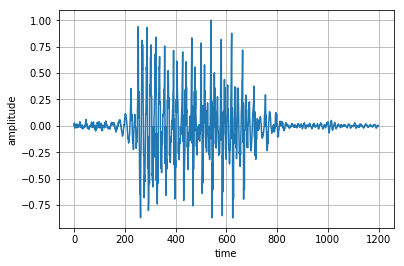

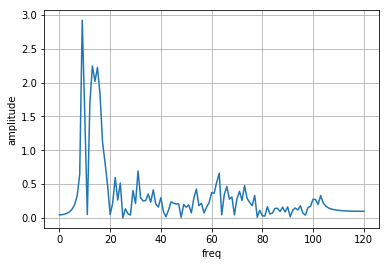

In [237]:
# load a wave, plot and play
#fileName = 'data/filteredNumbers/01_aa570a1398.wav' 
fileName = 'data/trainingNums/06_1507906720.wav'

data, sample_rate = sf.read(fileName)
print(sample_rate)
print(len(data))
duration = len(data)//5
print(duration)

plt.figure()
plt.plot(data)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

mags = abs(np.real(np.fft.rfft(data[:duration])))
print(mags.shape)
plt.figure()
plt.plot(mags)
plt.xlabel('freq')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

#clippedSamples = clip_audio(data)
Audio(data, rate=sample_rate)